<a href="https://colab.research.google.com/github/AnIsAsPe/RNN-Resumenes-de-Texto/blob/main/Notebooks/Resumen_de_textos_usando_seq2seq_LSTM_w2v.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Cargar bibliotecas

In [1]:
!pip install contractions

     |████████████████████████████████| 327kB 7.4MB/s 
     |████████████████████████████████| 286kB 12.7MB/s 
  Created wheel for pyahocorasick: filename=pyahocorasick-1.4.2-cp37-cp37m-linux_x86_64.whl size=85401 sha256=88897f14e90fb364eb0d9f492bc5a56b8297f862df7255ee3978ab534e101cf3
  Stored in directory: /root/.cache/pip/wheels/3a/03/34/77e3ece0bba8b86bfac88a79f923b36d805cad63caeba38842
Successfully built pyahocorasick


In [2]:
import pandas as pd
import numpy as np

import gensim
import contractions
import re

import tensorflow as tf
from tensorflow import keras

import matplotlib.pyplot as plt

## Descomprimir archivo

In [3]:
#from zipfile import ZipFile
#with ZipFile('/content/drive/MyDrive/Datos/ReviewsAmazon.csv.zip', 'r') as zip_ref:
#    zip_ref.extractall('/content/drive/MyDrive/Datos/AmazonReviews')

# Leer datos de entrada

In [4]:
df = pd.read_csv('/content/drive/MyDrive/Datos/AmazonReviews/Reviews.csv',
                 nrows=100000, usecols=['Summary', 'Text'], )
df = df.drop_duplicates(keep='first', ignore_index = True).dropna()
print(df.shape)
df.head()

(88563, 2)


,Summary,Text
0,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...
2,"""Delight"" says it all",This is a confection that has been around a fe...
3,Cough Medicine,If you are looking for the secret ingredient i...
4,Great taffy,Great taffy at a great price. There was a wid...


In [5]:
np.random.seed = 15
muestra = np.random.choice(range(len(df)), 5)
for i in muestra:
    print("\nReview #", i)
    print(df.loc[i, 'Summary'])
    print(df.loc[i,'Text'])    


Review # 6802
Orange Tangerine Switch
This product is not a soda but a carbonated juice. This soda has a nice taste- its not as sweet and as pure orange-tasting as typical orange soda-like drinks. It's not pure orange juice- but made up of a mixture of several different juices including apple, orange, grape and tangerine.  That juice blend gives it a slightly tangy taste that is actually at first slightly surprising and mostly refreshing.  The carbonation also seems lighter to me than soda but it is definitely there.<br /><br />The things I like about this product are the smaller can size (8.3oz)which makes it a more appropriate serving that a regular soda.  I also like the bright packaging and the pleasant taste.  After reading the ingredients of SWITCH carefully- I see that it is all juice just as it claims- so its probably a better choice than a regular soda.<br /><br />This product has no added sugars just as advertised on the can- but buyer beware- its still kind of high in sugar

In [6]:
df.to_csv('Amazon_reviews_trim.csv', index=False)

# Preprocesamiento de texto
- convertir a minuscualas
- expandir contracciones
- eliminar puntuación


In [7]:
def preprocesar(texto):
    #quitar contracciones
    texto = contractions.fix(texto)

    #convertir en minúsculas
    texto = texto.lower()

    # eliminar texto no deseado
    texto = re.sub(r'<br />', ' ', texto)

    #texto = re.sub(r'https?:\/\/.*[\r\n]*', '', texto, flags=re.MULTILINE)
    #texto = re.sub(r'\<a href', ' ', texto)
    #texto = re.sub(r'&amp;', '', texto) 
    #texto = re.sub(r'[_"\-;%()|+&=*%.,!?:#$@\[\]/]', ' ', texto)
    #texto = re.sub(r'\'', ' ', texto)

    #dejar solo letras y números
    texto = re.sub('[^A-ZÜÖÄa-z0-9]+', ' ', texto)
    return(texto)

In [8]:
%%time
for col in df.columns:
  df[col] = df[col].apply(preprocesar)
  
df.loc[738,'Text']

CPU times: user 6.81 s, sys: 42.1 ms, total: 6.86 s
Wall time: 6.87 s


In [9]:
df['Summary'] = df['Summary'].apply(lambda x : 'tokenstart '+ x + ' tokenend')  #Identificador de comienzo y término

In [10]:
np.random.seed = 15
muestra = np.random.choice(range(len(df)), 5)
for i in muestra:
    print("\nReview #", i)
    print(df.loc[i, 'Summary'])
    print(df.loc[i,'Text'])    


Review # 13292
tokenstart to each their own tokenend
i was excited to try these pork rinds and so when they came i popped some in the microwave immediately if you are a traditional pork rind lover these are probably not for you they have the consistency of a rice cake although they taste like a pork rind it is not the same as the feel of a pork rind there is no air pockets or crackling sensation that you get with holding a regular rind in your mouth i am sure these are great for some but i am just not ready to call this good i gave my bag to a friend lesson learned 

Review # 55622
tokenstart instinct tokenend
my cat does not like this food sorry plus when received it was more dust in the bag then nibblets very disppointed

Review # 62512
tokenstart great energy bar tokenend
these bars are fantastic i love how they are not overly sweet like every other bar i have tasted ie luna and cliff bars i love that all i taste are gently sweet dried fruit and nuts not sugary crap that gives me a

# Limitar la cantidad de palabras en textos y resumenes

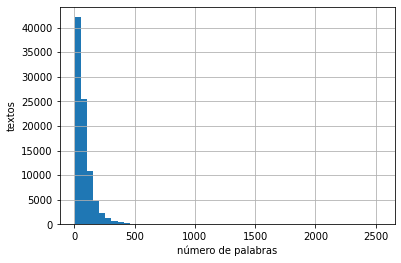


El 90% de los textos tiene 168 palabras


In [11]:
# ¿Cuantas palabras tienen cada texto?
palabras_textos = df['Text'].apply(lambda x: len(str(x).split()))

hist = palabras_textos.hist(bins=50)
hist.set_xlabel("número de palabras")
hist.set_ylabel("textos")
plt.show()

print('\nEl 90% de los textos tiene {:,.0f} palabras'.format(palabras_textos.quantile(0.90)))

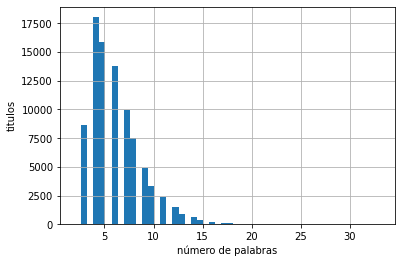


El 97.5% de los titulos tiene 13 palabras


In [12]:
# ¿Cuantas palabras tienen cada titulo?
palabras_titulos = df['Summary'].apply(lambda x: len(str(x).split()))

hist = palabras_titulos.hist(bins=50)
hist.set_xlabel("número de palabras")
hist.set_ylabel("titulos")
plt.show()

print('\nEl 97.5% de los titulos tiene {:,.0f} palabras'.format(palabras_titulos.quantile(0.975)))

In [13]:
longitud_max_textos = palabras_textos.quantile(0.90)     #168 palabras
longitud_max_titulos = palabras_titulos.quantile(0.975)  # 13 palabras

In [14]:
datos =  df[(palabras_textos <= longitud_max_textos ) & (palabras_titulos <= longitud_max_titulos)]
datos.shape   

(78650, 2)

# Dividir datos en conjunto de entrenamiento y prueba

In [15]:
from sklearn.model_selection import train_test_split

x_train, x_test, y_train, y_test = train_test_split(datos['Text'], 
                                                    datos['Summary'], 
                                                    test_size=0.1, 
                                                    shuffle=True, 
                                                    random_state=0)

In [16]:
print('{} reseñas en el conjunto de entrenamiento\n{} reseñas en el conjunto de prueba'.format(len(x_train), len(x_test)))

70785 reseñas en el conjunto de entrenamiento
7865 reseñas en el conjunto de prueba


# Vectorización del texto

[Referencia](https://keras.io/examples/nlp/pretrained_word_embeddings/):


In [17]:
from tensorflow.keras.layers.experimental.preprocessing import TextVectorization  
from tensorflow.data import Dataset

### Paso 1 Diccionario de vocabulario con clave y vectorizador de textos

In [18]:
def genera_dic_vocabulario(serie_pd, max_tokens= 20000):
  '''Obtiene el vocabulario de una serie de pandas con textos en forma de 
  diccionario, donde cada palabra es una clave y el valor es un indice'''
  vectorizer = TextVectorization(max_tokens = max_tokens  )  
  text_ds = Dataset.from_tensor_slices(serie_pd).batch( 128)  
  vectorizer.adapt(text_ds)   #similar a fit 
  voc = vectorizer.get_vocabulary()  # lista con el vocabulario
  #diccionario con el vocabulario
  dic_vocabulario = dict(zip(voc, range(len(voc))))
  return dic_vocabulario, vectorizer

In [19]:
%%time
vocabulario_dic, vectorizer_reseña = genera_dic_vocabulario(x_train)

CPU times: user 2.93 s, sys: 405 ms, total: 3.34 s
Wall time: 7.95 s


In [20]:
ejemplos = ['got', 'wild', 'hair', 'ordered', 'pound', 'bag']
[vocabulario_dic[palabra] for palabra in ejemplos]

[141, 1225, 580, 161, 654, 110]

In [21]:
vectorizer_reseña(ejemplos)

<tf.Tensor: shape=(6, 1), dtype=int64, numpy=
array([[ 141],
       [1225],
       [ 580],
       [ 161],
       [ 654],
       [ 110]])>

In [22]:
vocabulario_dic.keys()

dict_keys(['', '[UNK]', 'the', 'i', 'and', 'a', 'it', 'to', 'is', 'of', 'this', 'not', 'for', 'in', 'my', 'have', 'that', 'but', 'are', 'you', 'with', 'was', 'they', 'like', 'as', 'on', 'these', 'so', 'them', 'good', 'great', 'taste', 'will', 'very', 'be', 'can', 'at', 'product', 'just', 'one', 'do', 'or', 'would', 'all', 'flavor', 'if', 'coffee', 'we', 'love', 'am', 'from', 'when', 'tea', 'has', 'had', 'more', 'me', 'than', 'amazon', 'no', 'out', 'get', 'really', 's', 'other', 'too', 'food', 'only', 'some', 'up', 'much', 'about', 'were', 'price', 'buy', 'best', 'because', 'little', 'time', 'an', 'use', 'there', 'tried', 'also', 'your', 'find', 'did', 'what', 'better', 'chocolate', 'well', 'he', 'make', 'been', 'does', 'she', 'even', 'dog', 'try', 'eat', 'which', 'by', 'after', 'now', 'any', 'again', 'drink', 'our', 'could', 'sugar', 'bag', 'sweet', 'bought', 'found', 'first', '2', 'cup', 'used', 'her', 'their', 'tastes', 'made', 'order', 'free', 'delicious', 'store', 'then', 'box', 'r

In [23]:
len(vocabulario_dic)

20000

[UNK] se usa para cuando en nuevos ejemplos existan palabras que no se enciuentren en el diccionario.

### Paso 2 Diccionario con vectores de palabras (embeddings) Word2Vec# 
Bajaremos los vectores word2vec preentrenados con el corpus GoogleNews.
Cuenta con 3 millones vectores de 300 dimensiones correspondientes a 3  palabras y frases en inglés


Referencia uso word embedings preentrenados con Keras en este [enlace](https://keras.io/examples/nlp/pretrained_word_embeddings/)


In [24]:
#!wget wget -c "https://s3.amazonaws.com/dl4j-distribution/GoogleNews-vectors-negative300.bin.gz"
#!gunzip /content/GoogleNews-vectors-negative300.bin.gz -d /content/drive/MyDrive/Datos/Embeddings/

In [25]:
from gensim.models import KeyedVectors  #comparación keyedVectors y fullmodels https://radimrehurek.com/gensim/models/keyedvectors.html

w2v = gensim.models.KeyedVectors.load_word2vec_format('/content/drive/MyDrive/Datos/Embeddings/GoogleNews-vectors-negative300.bin',
                                                        binary=True)

In [26]:
%%time
dic_embeddings_word2vec  = {palabra : w2v[palabra] for palabra in w2v.index2word}

CPU times: user 5.88 s, sys: 231 ms, total: 6.11 s
Wall time: 6.12 s


In [27]:
#Cantidad de palabras en modelo word2vec
len(dic_embeddings_word2vec)

3000000

In [28]:
print(dic_embeddings_word2vec ["got"].shape)
dic_embeddings_word2vec ["got"]

(300,)


array([ 0.06201172,  0.10839844, -0.09667969,  0.07910156,  0.03393555,
       -0.34765625, -0.06982422, -0.05249023, -0.1328125 ,  0.19140625,
       -0.04882812, -0.25195312, -0.00817871, -0.00964355, -0.05444336,
       -0.02270508,  0.10498047,  0.24511719,  0.01953125,  0.06933594,
       -0.18652344,  0.13671875,  0.30664062, -0.07324219,  0.26953125,
       -0.04589844,  0.04223633, -0.02502441,  0.14941406,  0.09228516,
        0.07519531,  0.02160645, -0.1015625 , -0.03710938,  0.15234375,
        0.02807617,  0.11083984,  0.00108337,  0.01696777,  0.03540039,
       -0.05224609, -0.2890625 ,  0.2265625 ,  0.09423828, -0.01452637,
       -0.12451172, -0.01977539, -0.23144531,  0.08105469, -0.02453613,
       -0.19140625,  0.16015625,  0.00387573, -0.01293945,  0.02294922,
        0.16113281,  0.12792969,  0.05859375,  0.00805664, -0.12695312,
        0.07226562,  0.2109375 , -0.08154297, -0.14453125, -0.05615234,
        0.03442383,  0.03417969, -0.02844238, -0.05029297,  0.14

### Paso 3 Obtener la matriz de vectores para todas las palabras del vocabulario 
embedding_texto()

In [29]:
def embedding_texto(dic_vocabulario, dic_embeddings_palabras, embedding_dim):
    num_tokens = len(dic_vocabulario.keys()) + 2  # se suman dos más para '' y '[UNK]'
    encontradas = 0
    # Inicializar matriz
    embedding_matrix = np.zeros((num_tokens, embedding_dim))
    for word, i in dic_vocabulario.items():
        embedding_vector = dic_embeddings_palabras.get(word)
        if embedding_vector is not None:
            # Words not found in embedding index will be all-zeros.
            # This includes the representation for "padding" and "OOV"
            embedding_matrix[i] = embedding_vector
            encontradas += 1
    proporcion = encontradas/len(dic_vocabulario) *100
    print("{} palabras vectorizadas, que representan {:.1f}% de todas las palabras en el corpus".format(encontradas, proporcion))
    return embedding_matrix

In [30]:
embedding_matrix = embedding_texto(vocabulario_dic, dic_embeddings_word2vec , 300)

17592 palabras vectorizadas, que representan 88.0% de todas las palabras en el corpus


In [31]:
embedding_matrix.shape

(20002, 300)


**Repetiremos el paso 1 y el paso 3 para crear el diccionario de los Resumenes.(el diccionario con vectores GloVe es el mismo)**

In [32]:
vocabulario_dic_sum, vectorizer_sum = genera_dic_vocabulario(y_train)
embedding_matrix_sum = embedding_texto(vocabulario_dic_sum, dic_embeddings_word2vec , 300)
embedding_matrix_sum.shape

10057 palabras vectorizadas, que representan 77.6% de todas las palabras en el corpus


(12958, 300)

## Paso 4. Preparar secuencia de entrada de la red neuronal


### Ejemplo de lo que haremos con todo el corpus tanto de reseñas, como de resumenes

In [33]:
ejemplos = datos.loc[5:7,'Text']
for ej in ejemplos:
  print(len(ej.split()))
  print(ej)

73
i got a wild hair for taffy and ordered this five pound bag the taffy was all very enjoyable with many flavors watermelon root beer melon peppermint grape etc my only complaint is there was a bit too much red black licorice flavored pieces just not my particular favorites between me my kids and my husband this lasted only two weeks i would recommend this brand of taffy it was a delightful treat 
51
this saltwater taffy had great flavors and was very soft and chewy each candy was individually wrapped well none of the candies were stuck together which did happen in the expensive version fralinger s would highly recommend this candy i served it at a beach themed party and everyone loved it 
24
this taffy is so good it is very soft and chewy the flavors are amazing i would definitely recommend you buying it very satisfying 


In [34]:
ejemplos_vec = ejemplos.apply(vectorizer_reseña)
for ej in ejemplos_vec:
  print(len(ej))
  print(ej)

73
tf.Tensor(
[   3  141    5 1225  580   12 2809    4  161   10  721  654  110    2
 2809   21   43   33 1384   20  150  148 2385 1594 1206 6392 1343 1229
  486   14   67  980    8   81   21    5  138   65   70  497  337  844
  356  415   38   11   14  827  883  614   56   14  322    4   14  327
   10 1641   67  136  600    3   42  128   10  164    9 2809    6   21
    5 1699  203], shape=(73,), dtype=int64)
51
tf.Tensor(
[  10    1 2809   54   30  148    4   21   33  423    4  623  252  305
   21 1305  983   90  797    9    2  984   72 1067  728  100   86 1712
   13    2  290  513    1   63   42  231  128   10  305    3 1079    6
   36    5 3034 4561 1050    4  444  276    6], shape=(51,), dtype=int64)
24
tf.Tensor(
[  10 2809    8   27   29    6    8   33  423    4  623    2  148   18
  427    3   42  197  128   19  201    6   33  785], shape=(24,), dtype=int64)


In [36]:
from tensorflow.keras.preprocessing.sequence import pad_sequences
# https://www.tensorflow.org/api_docs/python/tf/keras/preprocessing/sequence/pad_sequences


ejemplos_seq =  pad_sequences(ejemplos_vec, maxlen = int(longitud_max_textos), padding='post')
for ej in ejemplos_seq:
  print(len(ej))
  print(ej)

168
[   3  141    5 1225  580   12 2809    4  161   10  721  654  110    2
 2809   21   43   33 1384   20  150  148 2385 1594 1206 6392 1343 1229
  486   14   67  980    8   81   21    5  138   65   70  497  337  844
  356  415   38   11   14  827  883  614   56   14  322    4   14  327
   10 1641   67  136  600    3   42  128   10  164    9 2809    6   21
    5 1699  203    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0]
168
[  10    1 2809   54   30  148    4   21   33  423    4  623  252  305
   21 1305  983   90  797    9    2  984   72 1067  728  100   86 17

In [37]:
%%time
x_train_vec = x_train.apply(vectorizer_reseña)
x_test_vec = x_test.apply(vectorizer_reseña)

y_train_vec = y_train.apply(vectorizer_sum)
y_test_vec = y_test.apply(vectorizer_sum)

CPU times: user 12min 20s, sys: 1min 22s, total: 13min 42s
Wall time: 11min 47s


In [38]:
%%time

x_train_seq  =  pad_sequences(x_train_vec, maxlen = int(longitud_max_textos), padding='post') 
x_test_seq  =  pad_sequences(x_test_vec, maxlen = int(longitud_max_textos), padding='post') 

y_train_seq  =  pad_sequences(y_train_vec, maxlen = int(longitud_max_titulos) , padding='post') 
y_test_seq  =  pad_sequences(y_test_vec, maxlen = int(longitud_max_titulos) , padding='post') 

CPU times: user 1min 4s, sys: 9.68 s, total: 1min 14s
Wall time: 58.8 s


# Diseño del modelo

* [referencia1](https://www.analyticsvidhya.com/blog/2019/06/comprehensive-guide-text-summarization-using-deep-learning-python/)

* [referencia2](https://humboldt-wi.github.io/blog/research/information_systems_1920/nlp_text_summarization_techniques/) 

## Diseño del codificador y decodificador

Codificador 3 capas con 3 LTSM y 320 dimensiones latentes


In [39]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Embedding, Input
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.layers import Concatenate, Attention
from tensorflow.keras.layers import TimeDistributed
from tensorflow.keras import backend as K 


In [40]:
num_tokens_rev = len(vocabulario_dic) + 2
num_tokens_sum = len(vocabulario_dic_sum) + 2
embedding_dim = 300

In [41]:
K.clear_session() 
latent_dim = 320

# CODIFICADOR   ================================================================

## EMBEDDING
   #recibe la secuencia de entrada para obtener una matriz longitud máxima x dim_embedding
encoder_inputs = Input(shape = (int(longitud_max_textos),))

enc_emb_lay = Embedding(num_tokens_rev, embedding_dim,
                    embeddings_initializer=keras.initializers.Constant(embedding_matrix),
                    trainable=False)
enc_emb = enc_emb_lay(encoder_inputs)     

#LSTM 1
  #recibe la matriz del embeding para obtener el estado oculto, 
encoder_lstm1 = LSTM(latent_dim,return_sequences=True, return_state=True)
encoder_output1, state_h1, state_c1 = encoder_lstm1(enc_emb) 


# LSTM 2
encoder_lstm2 = LSTM(latent_dim,return_sequences=True,return_state=True) 
encoder_output2, state_h2, state_c2 = encoder_lstm2(encoder_output1) 

#LSTM 3 
encoder_lstm3=LSTM(latent_dim, return_state=True, return_sequences=True) 
encoder_outputs, state_h, state_c= encoder_lstm3(encoder_output2) 


# DECODIFICADOR ================================================================

decoder_inputs = Input(shape=(None,)) 
dec_emb_layer = Embedding(num_tokens_sum, embedding_dim,
                    embeddings_initializer=keras.initializers.Constant(embedding_matrix_sum),
                    trainable=False)
dec_emb = dec_emb_layer(decoder_inputs)

#LSTM 
decoder_lstm = LSTM(latent_dim, return_sequences=True, return_state=True) 
decoder_outputs,decoder_fwd_state, decoder_back_state = decoder_lstm(dec_emb,initial_state=[state_h, state_c]) 




##Attention Layer

Fuente: https://github.com/madhav727/abstractive-news-summary

In [42]:
!cp drive/MyDrive/Datos/attention.py .


In [43]:
from attention import AttentionLayer

In [44]:
attn_layer = AttentionLayer(name='attention_layer') 
attn_out, attn_states = attn_layer([encoder_outputs, decoder_outputs])  #concatena los estados ocultos del codificador y del decodificador para construir el vector de contexto

## Union del modelo

In [45]:
embedding_matrix_sum.shape

(12958, 300)

In [46]:
embedding_matrix_sum.shape[0]

12958

In [47]:
# Unión de la salida del decodificador(distribución del vocabulario probeniente de los resumenes
# y el vector de contexto delmódulo de atención en la capa con activación softmax

decoder_concat_input = Concatenate(axis=-1, name='concat_layer')([decoder_outputs, attn_out])
decoder_dense = TimeDistributed(Dense(embedding_matrix_sum.shape[0], activation='softmax')) 
decoder_outputs = decoder_dense(decoder_concat_input) 

# Modelo definitivo
model = Model([encoder_inputs, decoder_inputs], decoder_outputs) 



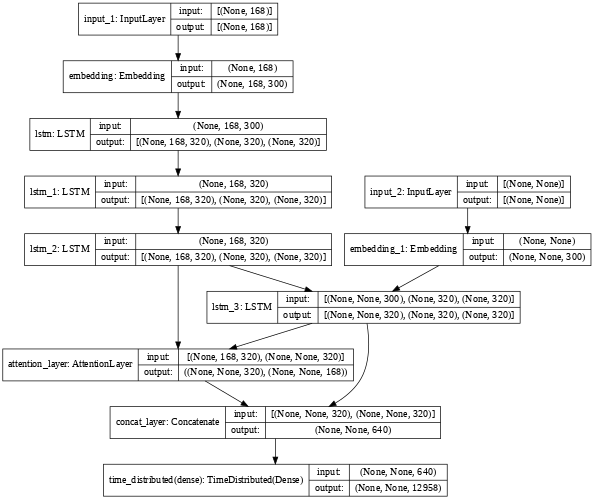

In [48]:
tf.keras.utils.plot_model( 
    model,
    to_file="model.png",
    show_shapes=True,
    show_dtype=False,
    show_layer_names=True,
    rankdir="TD",
    dpi=50,
)

In [49]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 168)]        0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, 168, 300)     6000600     input_1[0][0]                    
__________________________________________________________________________________________________
lstm (LSTM)                     [(None, 168, 320), ( 794880      embedding[0][0]                  
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, None)]       0                                            
______________________________________________________________________________________________

# Entrenamiento del modelo

In [50]:
model.compile(optimizer='rmsprop', 
              loss='sparse_categorical_crossentropy')

In [51]:
%%time

from tensorflow.keras.callbacks import EarlyStopping
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1) 

history = model.fit([x_train_seq, y_train_seq[:,:-1]], 
                    y_train_seq.reshape(y_train_seq.shape[0],
                                        y_train_seq.shape[1], 1)[:,1:],
                    epochs = 50, 

                    #terminar antes cuando no disminuya la función de pérdida
                    callbacks = [EarlyStopping(monitor='val_loss',mode='min', 
                                             verbose=1)],
                    batch_size = 512, 
                    validation_data = ([x_test_seq,y_test_seq[:,:-1]], 
                                     y_test_seq.reshape(y_test_seq.shape[0],
                                                        y_test_seq.shape[1],
                                                        1)[:,1:]))


Epoch 1/50
139/139 [==============================] - 174s 983ms/step - loss: 3.2951 - val_loss: 2.3076
Epoch 2/50
139/139 [==============================] - 137s 982ms/step - loss: 2.2159 - val_loss: 2.1469
Epoch 3/50
139/139 [==============================] - 137s 987ms/step - loss: 2.0462 - val_loss: 2.0343
Epoch 4/50
139/139 [==============================] - 138s 993ms/step - loss: 1.9339 - val_loss: 1.9744
Epoch 5/50
139/139 [==============================] - 138s 992ms/step - loss: 1.8580 - val_loss: 1.9238
Epoch 6/50
139/139 [==============================] - 138s 993ms/step - loss: 1.7998 - val_loss: 1.8875
Epoch 7/50
139/139 [==============================] - 138s 993ms/step - loss: 1.7299 - val_loss: 1.8273
Epoch 8/50
139/139 [==============================] - 138s 991ms/step - loss: 1.6781 - val_loss: 1.8082
Epoch 9/50
139/139 [==============================] - 139s 1s/step - loss: 1.6304 - val_loss: 1.7844
Epoch 10/50
139/139 [==============================] - 138s 991ms/s

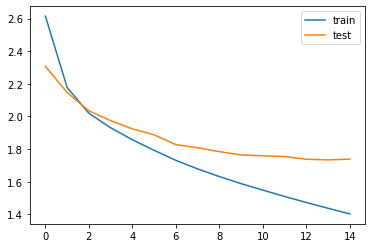

In [52]:
plt.plot(history.history['loss'], label='train') 
plt.plot(history.history['val_loss'], label='test') 
plt.legend() 
plt.show()

In [53]:
#Guardar todo el modelo
model.save('/content/drive/MyDrive/Modelos/rrn_modelo_LSTM_w2v')

INFO:tensorflow:Assets written to: /content/drive/MyDrive/Modelos/rrn_modelo_LSTM_w2v/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/Modelos/rrn_modelo_LSTM_w2v/assets


In [54]:
#modelo = tf.keras.models.load_model('/content/drive/MyDrive/Modelos/rrn_modelo_w2v')

# Check its architecture
#modelo.summary()

#Invertir diccionario de vocabulario
El objetivo es que a partir de indice, regrese palabras

In [55]:
reversed_vocabulario_dic_sum = dict(map(reversed, vocabulario_dic_sum.items()))
reversed_vocabulario_dic_text = dict(map(reversed, vocabulario_dic.items()))


#Modelo de Inferencia y Generación de Texto

In [56]:
## Inferencia del codificador
encoder_model = Model(inputs=encoder_inputs, outputs=[encoder_outputs, state_h, state_c])

# Inferencia del decodificador

decoder_state_input_h = Input(shape=(latent_dim,))
decoder_state_input_c = Input(shape=(latent_dim,))
decoder_hidden_state_input = Input(shape=(int(longitud_max_textos), latent_dim))

# Obtener los embeddings de la secuencia del decodificador 
dec_emb2 = dec_emb_layer(decoder_inputs)

# Para predecir la siguiente palabra, el estado inicial se iguala al estado del tiempo anterior
decoder_outputs2, state_h2, state_c2 = decoder_lstm(dec_emb2, initial_state=[decoder_state_input_h, decoder_state_input_c])

#Inferencia en modulo de atención
attn_out_inf, attn_states_inf = attn_layer([decoder_hidden_state_input, decoder_outputs2])
decoder_inf_concat = Concatenate(axis=-1, name='concat')([decoder_outputs2, attn_out_inf])

# Se utiliza la capa con activación softmax para generar la distribución de probabilidad del vocabulario objetivo
decoder_outputs2 = decoder_dense(decoder_inf_concat)

# Modelo final del decoder
decoder_model = Model(
[decoder_inputs] + [decoder_hidden_state_input,decoder_state_input_h, decoder_state_input_c],
[decoder_outputs2] + [state_h2, state_c2])

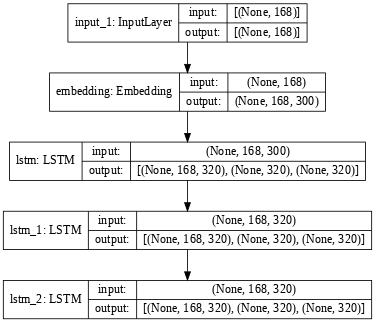

In [57]:
tf.keras.utils.plot_model( 
    encoder_model,
    to_file="encoder_model.png",
    show_shapes=True,
    show_dtype=False,
    show_layer_names=True,
    rankdir="TD",
    dpi=60,
)

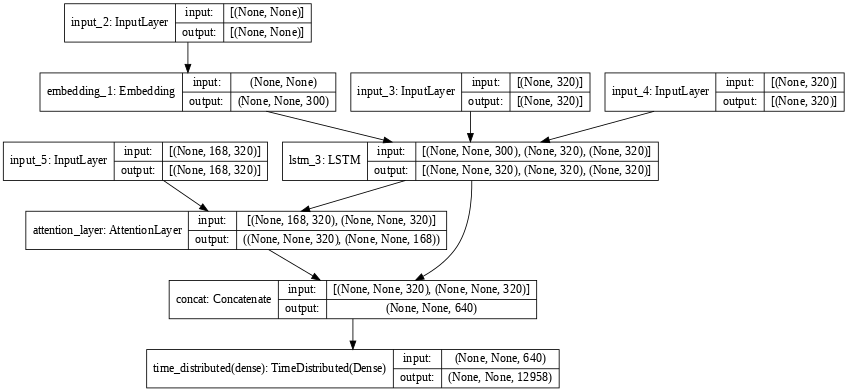

In [58]:
tf.keras.utils.plot_model( 
    decoder_model,
    to_file="model_decoder.png",
    show_shapes=True,
    show_dtype=False,
    show_layer_names=True,
    rankdir="TD",
    dpi=60,
)

# Implementación del modelo de inferencia mediante decode_sequence()

[fuente](https://www.analyticsvidhya.com/blog/2019/06/comprehensive-guide-text-summarization-using-deep-learning-python/)

In [60]:
def crea_resumen(input_seq):
    # Codifica el texto como vectores de entrada
    e_out, e_h, e_c = encoder_model.predict(input_seq)

    # Genera una secuencia vacía de longitud 1.
    target_seq = np.zeros((1,1))

    # Identifica la palabra 'tokenstart' como la primera palabra de la secuencia objetivo
    target_seq[0, 0] =  vocabulario_dic_sum['tokenstart']

    stop_condition = False
    decoded_sentence = ''
    while not stop_condition:
        output_tokens, h, c = decoder_model.predict([target_seq] + [e_out, e_h, e_c])

        # Escoje la proxima palabra para el resumen
        sampled_token_index = np.argmax(output_tokens[0, -1, :])
        sampled_token = reversed_vocabulario_dic_sum[sampled_token_index]

        # Mientras la palabra elejida no sea la final 'tokenend', anexa la palabra elejida al resumen
        if sampled_token!='tokenend':
            decoded_sentence += ' '+sampled_token

        # Sal del ciclo while si se alcanza la longitud máxima o si se encuentra 'tokenend'.
        if (sampled_token == 'tokenend' or len(decoded_sentence.split()) >= (int(longitud_max_titulos-1))):
                stop_condition = True

        # Actualiza la secuencia objetivo (of length 1).
        target_seq = np.zeros((1,1))
        target_seq[0, 0] = sampled_token_index

        # Actualiza los estados internos para predecir la siguiente palabra, igualandolos al estado del tiempo anterior
        e_h, e_c = h, c

    return decoded_sentence

In [61]:
def seq2summary(input_seq):
    newString = ''
    for i in input_seq:
      if((i != 0 and i != vocabulario_dic_sum['tokenstart']) and i != vocabulario_dic_sum['tokenend']):
        newString = newString + reversed_vocabulario_dic_sum[i]+' '
    return newString

def seq2text(input_seq):
    newString = ''
    for i in input_seq:
      if(i != 0):
        newString = newString + reversed_vocabulario_dic_text[i]+' '
    return newString

In [63]:
x_test.iloc[0]

'we tried spelt pasta after we discovered wheat allergies in our family and the allergist said spelt might not because the same issues we have tried the shells and elbows we prefer the elbows as a pasta dish as the shells are very small but the taste is equally good and we have had no trouble switching from the white or wheat flour variety pastas '

In [64]:
y_test.iloc[0]

'tokenstart good tasting pasta tokenend'

In [66]:
for i in range(10, 20):
  print(i)
  print("Review:",seq2text(x_test_seq[i]))
  print("Original summary:",seq2summary(y_test_seq[i]))
  print("Predicted summary:",crea_resumen(x_test_seq[i].reshape(1, -1)))
  print("\n")

10
Review: reasonable in price tastes good prefect for keurig which can be pricey we will probably buy this again it is mostly for the kiddos anyway 
Original summary: good for the money 
Predicted summary:  great price


11
Review: my family and i thoroughly enjoyed the quinoa the shipment arrived as described and in a nice sturdy container there will be many future orders 
Original summary: quinoa 
Predicted summary:  great product


12
Review: this oil has got to be the best tasting oil i have ever tasted very addictive as a dip with good bread five stars love it 
Original summary: delicious 
Predicted summary:  best olive oil ever


13
Review: not at all what we had hoped for as our anniversary gift from mil tiny packages often not enough to share hot choc for 1 seriously only 2 truffles no branded products at all 2 cookies and the brie is not even the real thing but some pasteurized cheese product please i might just as well be eating velveeta also shipped on a [UNK] day and sat i